In [1]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
num_epochs = 10
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length
num_layers = 3

In [3]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

In [4]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])

state_per_layer_list = tf.unstack(init_state, axis=0)
rnn_tuple_state = tuple(
    [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
     for idx in range(num_layers)]
)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [6]:
# Unpack columns
inputs_series = tf.split(batchX_placeholder, truncated_backprop_length, 1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward passes
cell = tf.contrib.rnn.LSTMCell(state_size, state_is_tuple=True)
cell = tf.contrib.rnn.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, initial_state=rnn_tuple_state)

In [7]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [8]:
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
Step 0 Batch loss 0.691919
Step 100 Batch loss 0.620822
Step 200 Batch loss 0.598076
Step 300 Batch loss 0.502309
Step 400 Batch loss 0.302033
Step 500 Batch loss 0.144799
Step 600 Batch loss 0.00670407
New data, epoch 1
Step 0 Batch loss 0.489146
Step 100 Batch loss 0.00310392
Step 200 Batch loss 0.00203834
Step 300 Batch loss 0.00197354
Step 400 Batch loss 0.00114208
Step 500 Batch loss 0.00114914
Step 600 Batch loss 0.000978921
New data, epoch 2
Step 0 Batch loss 0.425597
Step 100 Batch loss 0.000747605
Step 200 Batch loss 0.000629315
Step 300 Batch loss 0.00074707
Step 400 Batch loss 0.000553632
Step 500 Batch loss 0.000663881
Step 600 Batch loss 0.00045795
New data, epoch 3
Step 0 Batch loss 0.314911
Step 100 Batch loss 0.000448868
Step 200 Batch loss 0.000444953
Step 300 Batch loss 0.000397714
Step 400 Batch loss 0.000438245
Step 500 Batch loss 0.000407686
Step 600 Batch loss 0.000337392
New data, epoch 4
Step 0 Batch loss 0.500967
Step 100 Batch loss 0.00039433

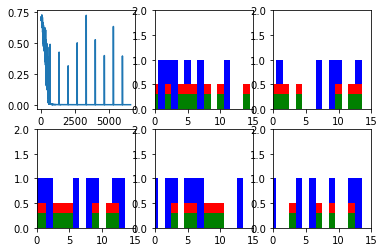

In [11]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()

        _current_state = np.zeros((num_layers, 2, batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    init_state: _current_state
                })


            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Batch loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()
